In [2]:
import pickle 

import numpy as np
np.set_printoptions(precision=3, suppress=True)

import cirq 
import cirq_google
import qsimcirq

from circuits import *
from utils import *

import matplotlib.pyplot as plt

## Initializing the simulator

In [3]:
processor_id = "willow_pink"
device = cirq_google.engine.create_device_from_processor_id(processor_id)
gateset = device.metadata.compilation_target_gatesets[0]
connectivity_graph = device.metadata.nx_graph

noise_props = cirq_google.engine.load_device_noise_properties(processor_id)
noise_model = cirq_google.NoiseModelFromGoogleNoiseProperties(noise_props)
sim = qsimcirq.QSimSimulator(noise=noise_model)
cal = cirq_google.engine.load_median_device_calibration(processor_id)
sim_processor = cirq_google.engine.SimulatedLocalProcessor(
    processor_id=processor_id, sampler=sim, device=device, calibrations={cal.timestamp // 1000: cal})
sim_engine = cirq_google.engine.SimulatedLocalEngine([sim_processor])

def process_circuit(circuit, mapping, connectivity_graph, gateset):
    router = cirq.RouteCQC(connectivity_graph)
    routed_circuit, initial_map, final_map =\
        router.route_circuit(circuit, initial_mapper=cirq.HardCodedInitialMapper(mapping))
    optimized_circuit = cirq.optimize_for_target_gateset(routed_circuit,\
                                context=cirq.TransformerContext(deep=True), gateset=gateset)
    device.validate_circuit(optimized_circuit)
    logical_to_physical_qubits = dict([(k, final_map[v]) for k, v in initial_map.items()])
    return optimized_circuit, logical_to_physical_qubits

def noisy_simulation(sim_engine, processor_id, circuit, N=10000, n_outcomes=None):
    samples = sim_engine.get_sampler(processor_id).run(circuit, repetitions=N)
    counts = samples.histogram(key="result")
    if type(n_outcomes) != None:
        for i in range(n_outcomes):
            if i not in counts:
                counts[i] = 0
    noisy_freqs = np.array([v for k, v in sorted(counts.items())])/N
    return noisy_freqs

## Simple sky/ground circuits

Background: Do a SIC measurement on each SIC state, to get $P$ and $\Phi=P^{-1}$.

Ground: Prepare the |0> state, and do a computational basis measurement to get $q$.

Sky: 
1. Prepare the |0> state, and do a SIC to get $p$.
2. For each SIC state, do a computational basis measurement to get $C$.

We should have:

$$ q = C \Phi p $$

In [4]:
n = 2
d = 2**n
P_sic = np.array([[(d*(1 if i == j else 0) + 1)/(d*(d+1)) for j in range(d**2)] for i in range(d**2)])
Phi_sic = np.linalg.inv(P_sic)

In [5]:
q = cirq.LineQubit.range(2*n)
A, B = q[:n], q[n:2*n]

def sic_state(A, a1, a2):
    yield d4_fiducial(A)
    for i in range(a2):
        yield Z(A)
    for j in range(a1):
        yield X(A)

def simple_ak(A, B):
    yield d4_fiducial(B, conjugate=True)
    yield CXdag(B, A)
    yield Fdag(B)
    yield cirq.measure(*(A+B), key="result")

def sic_on_sic(A, B, a1, a2):
    yield sic_state(A, a1, a2)
    yield simple_ak(A, B)

def sic_on_state(A, B):
    # 0 state
    yield simple_ak(A, B)

def povm_on_sic(A, a1, a2):
    yield sic_state(A, a1, a2)
    yield cirq.measure(A, key="result") # basis measurement

def povm_on_state(A):
    # 0 state
    yield cirq.measure(A, key="result") # basis measurement

## Sky/ground experiments

In [6]:
mapping = {A[0]: cirq.GridQubit(5,9),\
           A[1]: cirq.GridQubit(6,9),\
           B[0]: cirq.GridQubit(5,10),\
           B[1]: cirq.GridQubit(6,10)}

def sic_on_sic_experiment(N):
    results = []
    for a1 in range(d):
        for a2 in range(d):
            circuit, qubit_map = process_circuit(cirq.Circuit(sic_on_sic(A, B, a1, a2)), mapping, connectivity_graph, gateset)
            results.append(noisy_simulation(sim_engine, processor_id, circuit, N=N, n_outcomes=d**2))
    P = np.array(results)
    Phi = np.linalg.inv(P)
    data = {"N": N, "P": P, "Phi": Phi, "simple_circuit": True,\
            "err": {"|P - P_sic|": np.linalg.norm(P - P_sic),\
                    "|Phi - Phi_sic|": np.linalg.norm(Phi - Phi_sic),\
                    "|I - Phi|": np.linalg.norm(np.eye(d**2) - Phi),\
                    "|I - Phi_sic|": np.linalg.norm(np.eye(d**2) - Phi_sic)}}
    with open("data/simple_sic_on_sic_N%d.pkl" % N, "wb") as f:
        pickle.dump(data, f)   
    return data

def sic_on_state_experiment(N):
    circuit, qubit_map = process_circuit(cirq.Circuit(sic_on_state(A, B)), mapping, connectivity_graph, gateset)
    p = noisy_simulation(sim_engine, processor_id, circuit, N=N, n_outcomes=d**2)
    data = {"N": N, "p": p}
    with open("data/simple_sic_on_state_N%d.pkl" % N, "wb") as f:
        pickle.dump(data, f)   
    return data

def povm_on_sic_experiment(N):
    results = []
    for a1 in range(d):
        for a2 in range(d):
            circuit, qubit_map = process_circuit(cirq.Circuit(povm_on_sic(A, a1, a2)), mapping, connectivity_graph, gateset)
            results.append(noisy_simulation(sim_engine, processor_id, circuit, N=N, n_outcomes=d))
    C = np.array(results).T
    data = {"N": N, "C": C}
    with open("data/simple_povm_on_sic_N%d.pkl" % N, "wb") as f:
        pickle.dump(data, f)   
    return data

def povm_on_state_experiment(N):
    circuit, qubit_map = process_circuit(cirq.Circuit(povm_on_state(A)), mapping, connectivity_graph, gateset)
    p = noisy_simulation(sim_engine, processor_id, circuit, N=N, n_outcomes=d)
    data = {"N": N, "q": p}
    with open("data/simple_povm_on_state_N%d.pkl" % N, "wb") as f:
        pickle.dump(data, f)   
    return data

## How good is P as a function of N?

In [25]:
data = sic_on_sic_experiment(20000)

In [74]:
N_values = [1000, 5000, 10000, 20000]
data_sets = {}
for N in N_values:
    with open("data/simple_sic_on_sic_N%d.pkl" % N, "rb") as f:
        data = pickle.load(f)
        data_sets[N] = data
        print("N: %d" % data["N"])
        for k, v in data["err"].items():
            print("%s: %f" % (k, v))
        Psym = symmetrize(data["P"])
        print("|P_sym - P_sic|: %f" % np.linalg.norm(Psym - P_sic))
        print()

N: 1000
|P - P_sic|: 0.277744
|Phi - Phi_sic|: 9.620661
|I - Phi|: 21.050341
|I - Phi_sic|: 15.491933
|P_sym - P_sic|: 0.196766

N: 5000
|P - P_sic|: 0.247965
|Phi - Phi_sic|: 8.209092
|I - Phi|: 20.437388
|I - Phi_sic|: 15.491933
|P_sym - P_sic|: 0.179474

N: 10000
|P - P_sic|: 0.254331
|Phi - Phi_sic|: 8.688257
|I - Phi|: 20.950817
|I - Phi_sic|: 15.491933
|P_sym - P_sic|: 0.186931

N: 20000
|P - P_sic|: 0.251227
|Phi - Phi_sic|: 8.435793
|I - Phi|: 20.794731
|I - Phi_sic|: 15.491933
|P_sym - P_sic|: 0.184802



## Testing sky/ground coherence

In [ ]:
N = 5000
sic_on_sic_experiment(N)
sic_on_state_experiment(N)
povm_on_sic_experiment(N)
povm_on_state_experiment(N);

In [16]:
povm_on_state_experiment(20000)

{'N': 20000, 'q': array([0.98685, 0.0027 , 0.01045, 0.     ])}

In [7]:
N = 5000
with open("data/simple_sic_on_sic_N%d.pkl" % N, "rb") as f:
    data = pickle.load(f)
    P = data["P"]
    Phi = np.linalg.inv(P)

with open("data/simple_sic_on_state_N%d.pkl" % N, "rb") as f:
    data = pickle.load(f)
    p = data["p"]

with open("data/simple_povm_on_sic_N%d.pkl" % N, "rb") as f:
    data = pickle.load(f)
    C = data["C"]

with open("data/simple_povm_on_state_N%d.pkl" % N, "rb") as f:
    data = pickle.load(f)
    q = data["q"]

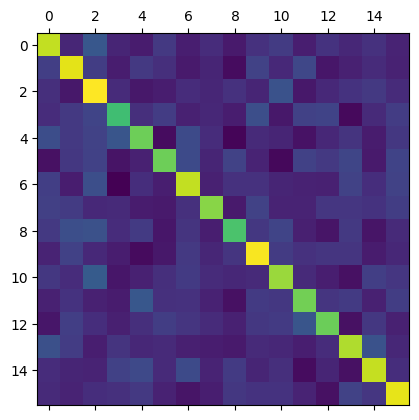

In [10]:
plt.matshow(P)

In [117]:
q_ = C @ Phi @ p; q_

array([ 0.793, -0.076,  0.04 ,  0.06 ])

In [13]:
q

array([0.9892, 0.0024, 0.0084, 0.    ])

In [12]:
np.set_printoptions(precision=10)

In [119]:
np.linalg.norm(q - q_)

np.float64(0.22189509214760644)

In [ ]:
q_fixed = q_[:]
q_fixed[q_fixed < 0] = 0
q_fixed = q_fixed/sum(q_fixed)
q_fixed

array([0.888, 0.   , 0.045, 0.067])

In [126]:
np.linalg.norm(q - q_fixed)

np.float64(0.12687373831670243)

In [11]:
P

array([[0.232, 0.047, 0.085, 0.046, 0.039, 0.06 , 0.041, 0.051, 0.038,
        0.055, 0.062, 0.041, 0.056, 0.047, 0.055, 0.045],
       [0.064, 0.244, 0.064, 0.04 , 0.06 , 0.053, 0.038, 0.045, 0.03 ,
        0.068, 0.049, 0.071, 0.036, 0.043, 0.051, 0.044],
       [0.053, 0.037, 0.253, 0.05 , 0.037, 0.04 , 0.051, 0.047, 0.054,
        0.046, 0.08 , 0.036, 0.048, 0.056, 0.06 , 0.051],
       [0.052, 0.06 , 0.069, 0.182, 0.053, 0.063, 0.043, 0.048, 0.04 ,
        0.078, 0.036, 0.066, 0.069, 0.028, 0.05 , 0.063],
       [0.076, 0.06 , 0.067, 0.083, 0.202, 0.029, 0.073, 0.051, 0.025,
        0.05 , 0.046, 0.033, 0.048, 0.056, 0.04 , 0.06 ],
       [0.033, 0.059, 0.067, 0.034, 0.043, 0.202, 0.074, 0.046, 0.068,
        0.044, 0.027, 0.067, 0.06 , 0.07 , 0.038, 0.068],
       [0.065, 0.041, 0.077, 0.022, 0.052, 0.042, 0.232, 0.043, 0.054,
        0.055, 0.045, 0.044, 0.043, 0.067, 0.052, 0.067],
       [0.066, 0.062, 0.048, 0.049, 0.039, 0.039, 0.054, 0.212, 0.038,
        0.067, 0.045, 0.04